In [4]:
import numpy as np
import tensorflow as tf
import os
import random
import math
from sklearn.manifold import TSNE
import collections
import zipfile
from urllib.request import urlretrieve
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Train Word2Vec skip-gram model over Text8 data

The test data for the Large Text Compression Benchmark is the first 109 bytes of the English Wikipedia dump on Mar. 3, 2006

In [5]:
# Download teh data from the source website

url = 'http://mattmahoney.net/dc/'
filename = 'text8.zip'

save_path = os.path.join('data', filename)
if not os.path.exists(save_path):
    urlretrieve(url + filename, save_path)

In [6]:
# read data into string

def read_data(filename):
    with zipfile.ZipFile(os.path.join('data', filename)) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data Size', len(words))
print(words[:4])

Data Size 17005207
['anarchism', 'originated', 'as', 'a']


Build dictionary and replace rare words with UNK token. 

In [7]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1)) # select only most frequent words
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) # setting the index as the value
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary: # is the word one of the common ones?
            index = dictionary[word]
        else: # add to unknown word in the dictionary
            index = 0 # dictionary['UNK]
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words # reduce memory
# this outputs the data list which basicaltl is the words list from the document with each word substituted by 
# the ranking based on count of words. 0 is very unkcommon and 1 is most common

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5236, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate  raining batch for hte skip-gram model

In [8]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data) # in case we get more batches than the length of the data
    for i in range(batch_size // num_skips):
        target = skip_window # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1 ) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
for num_skips, skip_window in [(2, 1), (4, 2)]: # seems like num_skips has to be 2 times skip_window 
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips =', num_skips, 'and skip_window =', skip_window,':')
    print('\tbatch:', [reverse_dictionary[bi] for bi in batch])
    print('\tlabels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1 :
	batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
	labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2 :
	batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
	labels: ['anarchism', 'originated', 'term', 'a', 'of', 'as', 'term', 'originated']


### Train skip-gram model

In [9]:
batch_size = 128
embedding_size = 128 # Dimension of embedding vector
skip_window = 1 # how many words to consider left adn right
num_skips = 2 # how many times to reuse an input to generate a label
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    
    # Input data
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weigths = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weigths, softmax_biases, embed,
                                                     train_labels, num_sampled, vocabulary_size))
    
    # Optimizer
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [29]:
num_steps = 500001#100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 50000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 100000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.824070
Nearest to they: azhar, supplemented, addressing, monty, bribe, veal, basket, slave,
Nearest to known: hospitalization, twenty, asphyxiation, elmendorf, gladly, preserving, polynesian, embedding,
Nearest to one: zeppelins, integrase, coma, tramp, precolonial, longer, stenella, stretcher,
Nearest to were: consists, dialectical, antennae, nibble, miko, formulation, outsold, enthusiastically,
Nearest to are: publius, monuc, incl, somerville, rise, porter, neolithic, belgrade,
Nearest to may: priming, dragster, superconductors, bible, superjanet, strabo, rook, gareth,
Nearest to zero: occured, joysticks, komodo, bingham, propelled, collapse, pottery, arduous,
Nearest to into: some, cough, medici, dejima, bodyguards, focus, mariners, jun,
Nearest to at: selected, semiotic, routine, capra, reciprocal, detroit, foxe, weigh,
Nearest to than: soundboard, tobruk, partisan, slices, nist, slalom, numeral, interquartile,
Nearest to will: nomads, steward,

### Visualization of words

In [30]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

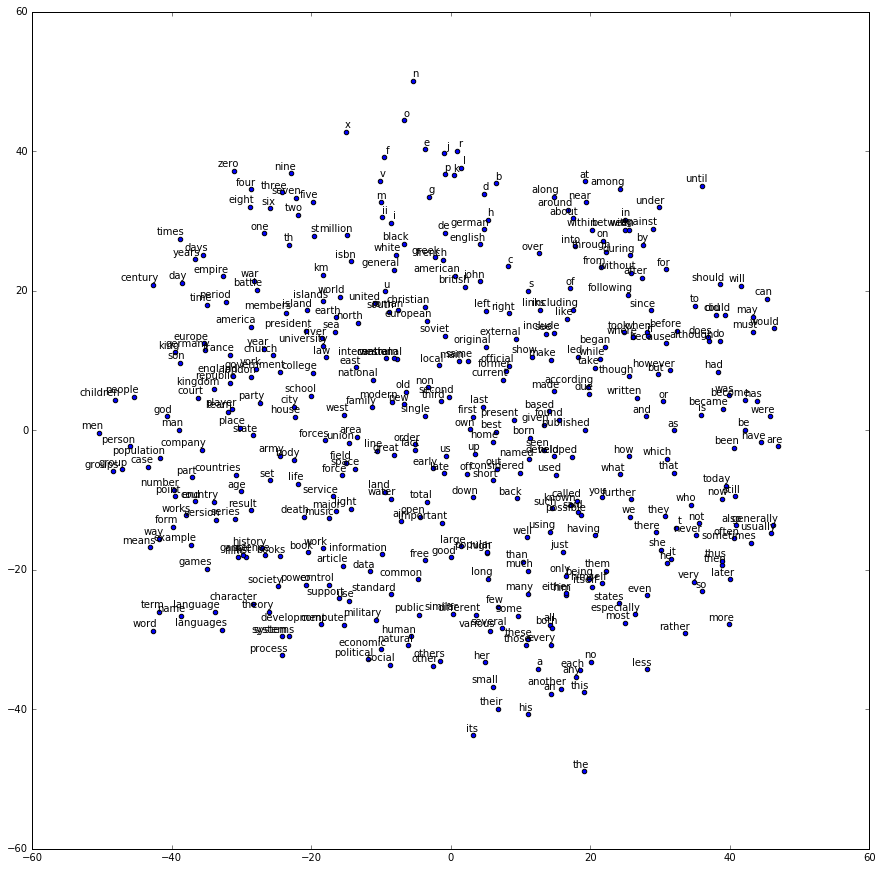

In [31]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))
#     plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
#         pylab.scatter(x, y)
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Problem

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

To put it more clearly lets thake an example and implement CBOW and skip-words with num_skips = 2 and skip_window = 1 and batch_size = 8:

#### sentence: anarchism originated as a term of abuse first.

### SKIP-WORD
Predict the context of a word from the word itself
- batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
- labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'of', 'a']

### CBOW
Predict word from teh context
- batch: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'of', 'a']
- labels: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']

So all that we need to do is to change batch for labels.



In [32]:
num_steps = 500001#100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        # HERE IS THE DIFFERENCE
        feed_dict = {train_dataset : batch_labels.flatten(), train_labels : batch_data.reshape((-1,1))}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 50000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 100000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.774854
Nearest to they: pokemon, scuderia, endow, customers, audiobook, colorless, shrubs, lizards,
Nearest to known: shattering, waterway, lazio, deeply, emanate, lamentations, edda, hring,
Nearest to one: epidemics, shula, grid, bartleby, ccp, deeper, hierarchy, khufu,
Nearest to were: dodecanese, dispelled, lifestyle, pneumonic, microbiology, orbits, brownlow, sported,
Nearest to are: cooley, thales, asks, asuras, lasi, kidding, loaf, varying,
Nearest to may: trimming, arm, ritualistic, martyred, manoel, tuition, crb, motherboards,
Nearest to zero: vm, xerxes, trout, drove, disassembled, octavio, ulfilas, libido,
Nearest to into: pretend, lambeth, needlessly, arrogance, trident, shostakovich, america, onyx,
Nearest to at: phytoplankton, alaska, aglaulus, frei, incas, sponsor, allahabad, dubliners,
Nearest to than: adapters, neurons, atlantean, seditious, hab, blew, reigned, saucers,
Nearest to will: bad, hominem, campaigned, poultry, labyrinths,

### VIsualization of words

In [33]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

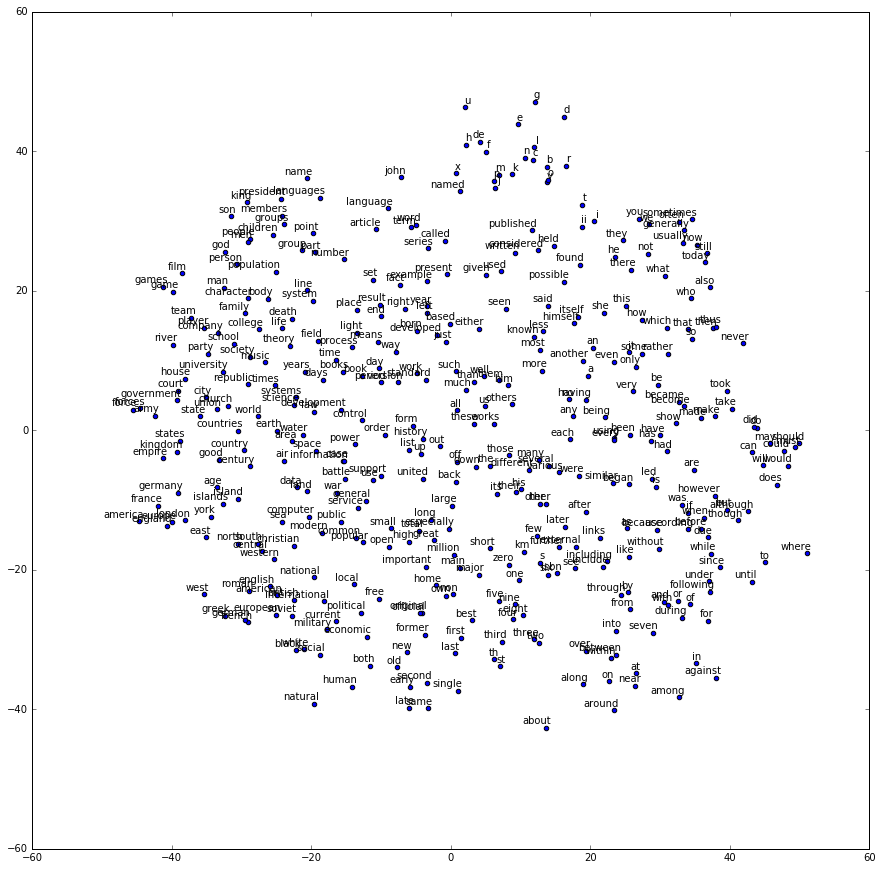

In [34]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))
#     plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
#         pylab.scatter(x, y)
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)